# Etapa 0 - Importo Librerías necesarias

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
import random
import os
import math
from keras.models import load_model


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from keras import optimizers 
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import SGD, Adam
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import keras.backend as K

from keras.models import Model, load_model
from keras import Input 
from keras.layers import Dense, LeakyReLU, BatchNormalization, Conv1D, Flatten, Concatenate, Reshape, RepeatVector, TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def show_history(history, metrics = []):
    """
    Visualize history
    :param history:
    :return:
    """
    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss history')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show();
    if not metrics:
        for metric in metrics:
            plt.plot(history.history[metric])
            plt.plot(history.history['val_' + metric])
            plt.title(metric + ' history')
            plt.ylabel(metric + ' value (%)')
            plt.xlabel('No. epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
def r2_keras(y_true, y_pred):
  """
  Custom R2-score metrics for keras backend
  :param y_true: valor real
  :type y_true: Tensor
  :param y_pred: valor predicho
  :type y_pred: Tensor
  :return: r2 score
  :rtype: tensor
  """
  ss_res = K.sum(K.square(y_true - y_pred))
  ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return 1 - ss_res / (ss_tot + K.epsilon())

def predict_weigths(data):
  lstm_model = keras.models.load_model('lstm_model.h5', compile=False)
  weigths_model = keras.models.load_model('weigths_model.h5', compile=False)

  returns_predicted = lstm_model.predict(data)
  weigths_predicted = weigths_model.predict(returns_predicted)

  weights_nn = []
  for j in range(weigths_predicted.shape[0]):
    weights_nn.append(weigths_predicted[j].mean(axis=0))
    
  weights_nn = np.array(weights_nn)

  return weights_nn

import sys


def preprocess(mat, M, N):
	# preprocess the matrix `mat` such that `s[i][j]` stores
	# sum of elements in the matrix from (0, 0) to (i, j)
	s = [[0 for x in range(len(mat[0]))] for y in range(len(mat))]
	s[0][0] = mat[0][0]

	# preprocess the first row
	for j in range(1, len(mat[0])):
		s[0][j] = mat[0][j] + s[0][j - 1]

	# preprocess the first column
	for i in range(1, len(mat)):
		s[i][0] = mat[i][0] + s[i - 1][0]

	# preprocess the rest of the matrix
	for i in range(1, len(mat)):
		for j in range(1, len(mat[0])):
			s[i][j] = mat[i][j] + s[i - 1][j] + s[i][j - 1] - s[i - 1][j - 1]

	return s


def findMaxSumSubMatrix(mat, k: int):

	# base case
	if len(mat) == 0:
		return []

	# `M × N` matrix
	(M, N) = (len(mat), len(mat[0]))

	# preprocess the matrix
	s = preprocess(mat, M, N)

	maximum = -sys.maxsize

	# find the maximum sum submatrix

	# start from cell (k-1, k-1) and consider each submatrix of size `k × k`
	for i in range(k - 1, M):
		for j in range(k - 1, N):

			# Note that (i, j) is the bottom-right corner coordinates of the
			# square submatrix of size `k`

			total = s[i][j]
			if i - k >= 0:
				total = total - s[i - k][j]

			if j - k >= 0:
				total = total - s[i][j - k]

			if i - k >= 0 and j - k >= 0:
				total = total + s[i - k][j - k]

			if total > maximum:
				maximum = total
				p = (i, j)

	# `p` stores bottom-right corner coordinates of the submatrix
	(x, y) = p

	# return maximum sum submatrix
	return [[mat[i + x - k + 1][j + y - k + 1] for j in range(k)] for i in range(k)]

def reset_random_seeds():
  os.environ['PYTHONHASHSEED']=str(1)
  tf.random.set_seed(1)
  np.random.seed(1)
  random.seed(1)

# Etapa 1: Obtencion de los datos


## 01 - Extracción de los datos

Para ello, se va a recurrir a la API de Yahoo Finance y se extraerán todos los datos históricos disponibles para las compañías listadas en el índice S&P500.

Además, para automatizar el proceso de obtención de estas empresas, se implementó técnicas de web-scrapping sobre Wikipedia.

In [ ]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

  Symbol     Security SEC filings  GICS Sector         GICS Sub-Industry  \
0    MMM           3M     reports  Industrials  Industrial Conglomerates   
1    AOS  A. O. Smith     reports  Industrials         Building Products   
2    ABT       Abbott     reports  Health Care     Health Care Equipment   
3   ABBV       AbbVie     reports  Health Care           Pharmaceuticals   
4   ABMD      Abiomed     reports  Health Care     Health Care Equipment   

     Headquarters Location Date first added      CIK      Founded  
0    Saint Paul, Minnesota       1976-08-09    66740         1902  
1     Milwaukee, Wisconsin       2017-07-26    91142         1916  
2  North Chicago, Illinois       1964-03-31     1800         1888  
3  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)  
4   Danvers, Massachusetts       2018-05-31   815094         1981  


Obtener el historico desde el 01-01-2009 hasta el dia de ejecución para las corporaciones desde la API de Yahoo Finance


In [ ]:
data = yf.download(tickers.Symbol.to_list(),'2009-1-2','2022-1-31', groupby='Ticker')

data.head()

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Adj Close                                                        \
                    A       AAL        AAP      AAPL ABBV        ABC   ABMD   
Date                                                                          
2009-01-02  10.586039  7.909601  32.126152  2.771174  NaN  14.545662  16.33   
2009-01-05  10.944558  7.853037  31.693272  2.888128  NaN  14.823733  16.00   
2009-01-06  11.818036  8.541239  31.740326  2.840492  NaN  14.766486  15.17   
2009-01-07  11.883222  8.560092  30.479370  2.779113  NaN  14.684696  14.70   
2009-01-08  11.961442  9.022035  30.582897  2.830720  NaN  15.015924  14.28   

                                             ...   Volume                     \
                  ABT        ACN       ADBE  ...     WYNN      XEL       XOM   
Date                                         ...                               
2009-01-02  18.741625  26.093245  23.020000  ...  1361400  2018300  35803700   
2009-01-05  18.419695  26.209497  23.129999  ...  3101200  2908200  43340100   
2009-01-06  17.817841  25.884010  24.219999  ...  3161300  3009200  41906100   
2009-01-07  17.719858  26.178495  24.230000  ...  3278200  2523000  35268800   
2009-01-08  17.915815  25.915001  24.290001  ...  1616800  2929700  30817100   

                                                                
               XRAY XYL      YUM      ZBH    ZBRA     ZION ZTS  
Date                                                            
2009-01-02  1574200 NaN  3612149  1147935  559600  1956500 NaN  
2009-01-05  1484200 NaN  6674574   914022  383100  1792800 NaN  
2009-01-06  2324700 NaN  4964340  1611641  298500  2187500 NaN  
2009-01-07  2345400 NaN  5347143  1297491  356900  2796800 NaN  
2009-01-08  1875600 NaN  5097737  1869553  511100  2087200 NaN  

[5 rows x 3024 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3292 entries, 2009-01-02 to 2022-01-28
Columns: 3024 entries, ('Adj Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2589), int64(435)
memory usage: 76.0 MB


In [ ]:
data.shape

(3292, 3024)

In [ ]:
data.to_csv('datos_tfm.csv')

# Etapa 2: Selección de los 5 activos

## 01 - Planto semilla

In [ ]:
reset_random_seeds()

## 02 - Importo los datos

In [ ]:
if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  df = data


In [ ]:
df.shape

(3292, 3024)

In [ ]:
autoencoder_data = df['Adj Close'].drop(columns= ["BF.B", "BRK.B"]).pct_change().dropna(how='all').fillna(0)

In [ ]:
autoencoder_data

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-05,0.033867,-0.007151,-0.013474,0.042204,0.000000,0.019117,-0.020208,-0.017177,0.004455,0.004778,...,0.102910,-0.009554,-0.000123,-0.032979,0.000000,0.027187,-0.020594,-0.013790,-0.026801,0.000000
2009-01-06,0.079809,0.087635,0.001485,-0.016494,0.000000,-0.003862,-0.051875,-0.032675,-0.012419,0.047125,...,0.056978,-0.012862,-0.016293,-0.026643,0.000000,-0.001825,0.018582,0.025072,0.033704,0.000000
2009-01-07,0.005516,0.002207,-0.039727,-0.021609,0.000000,-0.005539,-0.030982,-0.005499,0.011377,0.000413,...,-0.145622,-0.010315,-0.025529,0.002919,0.000000,-0.035660,-0.032405,0.000941,-0.102187,0.000000
2009-01-08,0.006582,0.053965,0.003397,0.018570,0.000000,0.022556,-0.028571,0.011059,-0.010065,0.002476,...,-0.016515,0.013165,0.010734,0.012009,0.000000,-0.004741,0.026793,-0.030545,-0.016829,0.000000
2009-01-09,0.009264,-0.059561,-0.022154,-0.022869,0.000000,-0.021514,-0.034314,-0.000586,0.008672,-0.011527,...,-0.051884,-0.012453,-0.019219,-0.014383,0.000000,-0.027628,0.012080,-0.057683,-0.018919,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,0.004436,0.006749,0.029449,-0.004864,0.001364,0.000228,0.024198,-0.015974,0.010041,0.039507,...,-0.009924,-0.011580,0.008591,0.017948,0.004669,0.016903,0.009058,-0.007325,0.016518,-0.001298
2022-01-25,-0.025702,0.003047,-0.011297,-0.011385,0.007037,-0.003725,-0.048407,-0.004442,-0.011947,-0.032598,...,0.019575,0.006674,0.029400,-0.021529,-0.034576,-0.033956,-0.021836,-0.033757,0.059105,-0.024092
2022-01-26,-0.007877,-0.013366,-0.021983,-0.000563,0.008566,-0.003891,0.001011,-0.025959,-0.015107,-0.003799,...,-0.003817,-0.003830,-0.010143,-0.003983,-0.012804,-0.015649,-0.003803,0.003587,0.010830,-0.027708


In [ ]:
autoencoder_data = autoencoder_data.T.copy()

In [ ]:
autoencoder_data 

Date,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-12,2009-01-13,2009-01-14,2009-01-15,2009-01-16,...,2022-01-14,2022-01-18,2022-01-19,2022-01-20,2022-01-21,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28
A,0.033867,0.079809,0.005516,0.006582,0.009264,0.000000,0.029158,-0.032004,0.036314,0.020397,...,-0.003375,-0.029099,-0.000285,-0.006765,-0.014124,0.004436,-0.025702,-0.007877,-0.010636,0.037626
AAL,-0.007151,0.087635,0.002207,0.053965,-0.059561,-0.051111,-0.031616,-0.106409,0.021651,0.129801,...,-0.043950,-0.031909,-0.032961,-0.031773,-0.027446,0.006749,0.003047,-0.013366,-0.028325,-0.008872
AAP,-0.013474,0.001485,-0.039727,0.003397,-0.022154,-0.029893,0.009406,-0.031812,0.015267,0.036940,...,-0.007127,-0.007053,-0.015006,-0.021379,-0.013867,0.029449,-0.011297,-0.021983,-0.000044,0.013815
AAPL,0.042204,-0.016494,-0.021609,0.018570,-0.022869,-0.021197,-0.010715,-0.027135,-0.022853,-0.012593,...,0.005111,-0.018894,-0.021025,-0.010347,-0.012765,-0.004864,-0.011385,-0.000563,-0.002943,0.069778
ABBV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017600,0.006698,-0.011478,-0.016123,-0.007893,0.001364,0.007037,0.008566,0.012963,0.014341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.027187,-0.001825,-0.035660,-0.004741,-0.027628,-0.003266,-0.020642,-0.033670,0.029617,0.012183,...,-0.013586,-0.005352,-0.014876,-0.007068,0.005015,0.016903,-0.033956,-0.015649,-0.002664,0.020197
ZBH,-0.020594,0.018582,-0.032405,0.026793,0.012080,-0.019575,-0.002191,-0.010981,0.004195,-0.003932,...,-0.005388,-0.008086,-0.024377,-0.001866,-0.004064,0.009058,-0.021836,-0.003803,0.006225,-0.002887
ZBRA,-0.013790,0.025072,0.000941,-0.030545,-0.057683,-0.032407,-0.017012,-0.016225,0.008796,0.009264,...,0.004184,-0.021364,-0.006986,-0.022783,-0.014439,-0.007325,-0.033757,0.003587,-0.005192,0.040868
ZION,-0.026801,0.033704,-0.102187,-0.016829,-0.018919,-0.044077,0.052353,-0.041990,-0.131015,-0.095943,...,0.008422,-0.017268,-0.046954,-0.029318,-0.038611,0.016518,0.059105,0.010830,-0.003125,0.017316


## 03 - Creo la red neuronal Autoencoder

In [ ]:
# This is the dimension of the original space
input_dim = autoencoder_data.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = int(autoencoder_data.shape[1] / 10)

encoder = Sequential([
    Dense(int(autoencoder_data.shape[1] / 2), activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(int(autoencoder_data.shape[1] / 4), activation='relu'),
    Dropout(0.3),
    Dense(int(autoencoder_data.shape[1] / 5), activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(latent_dim, activation=None)
])

decoder = Sequential([
    Dense(int(autoencoder_data.shape[1] / 5), activation='relu', input_shape=(latent_dim,)),
    Dropout(0.3),
    Dense(int(autoencoder_data.shape[1] / 4), activation='relu'),
    Dropout(0.3),
    Dense(int(autoencoder_data.shape[1] / 2), activation='relu'),
    Dropout(0.3),
    Dense(input_dim, activation=None)
])

In [ ]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mape', optimizer='Adam')
# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
early_stopping = EarlyStopping(monitor='loss', patience=50, mode='max', restore_best_weights=True)

Epoch 1/300
2/2 [==============================] - 2s 446ms/step - loss: 173676.8750
Epoch 2/300
2/2 [==============================] - 1s 391ms/step - loss: 37297.3555
Epoch 3/300
2/2 [==============================] - 1s 389ms/step - loss: 28678.9141
Epoch 4/300
2/2 [==============================] - 1s 388ms/step - loss: 22089.4375
Epoch 5/300
2/2 [==============================] - 1s 381ms/step - loss: 18677.2305
Epoch 6/300
2/2 [==============================] - 1s 397ms/step - loss: 18320.8203
Epoch 7/300
2/2 [==============================] - 1s 395ms/step - loss: 15153.7070
Epoch 8/300
2/2 [==============================] - 1s 395ms/step - loss: 15680.6855
Epoch 9/300
2/2 [==============================] - 1s 393ms/step - loss: 14709.6094
Epoch 10/300
2/2 [==============================] - 1s 383ms/step - loss: 12330.6973
Epoch 11/300
2/2 [==============================] - 1s 384ms/step - loss: 12635.0918
Epoch 12/300
2/2 [==============================] - 1s 377ms/step - loss:

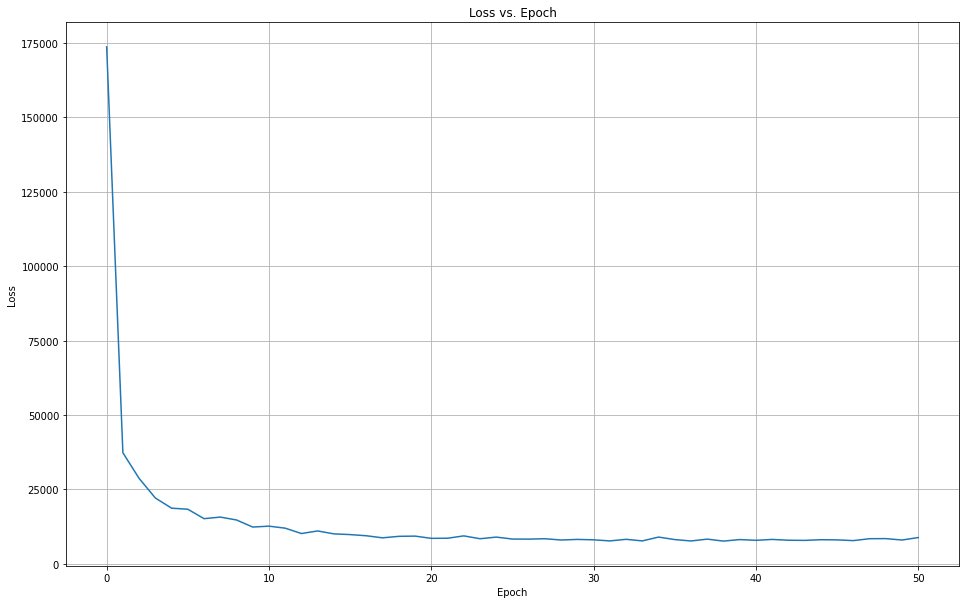

In [ ]:
model_history = autoencoder.fit(np.array(autoencoder_data),
                                np.array(autoencoder_data),
                                epochs=300,
                                batch_size=300,
                                callbacks=[early_stopping],
                                verbose=1,
                                shuffle=True)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [ ]:
# Compile before plotting
encoder.compile(loss='mape', optimizer='Adam')
decoder.compile(loss='mape', optimizer='Adam')

encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [ ]:
y_pred = encoder.predict(autoencoder_data)

In [ ]:
y_pred

array([[-7.5038020e-03, -4.6809297e-04, -2.4444307e-03, ...,
        -9.2517131e-04,  1.0156614e-02, -6.4495411e-03],
       [-5.3975461e-03,  2.4431404e-03, -6.3967514e-03, ...,
        -1.3792166e-02,  7.2599873e-03,  5.5387961e-03],
       [-9.7916471e-03, -3.6812499e-03, -2.9424168e-03, ...,
         1.9282789e-04,  3.1182868e-03, -6.9732554e-03],
       ...,
       [-9.5103448e-03, -2.9945374e-04, -7.8028971e-03, ...,
        -9.3344701e-03,  1.0772234e-02, -1.4635022e-03],
       [-5.4221582e-03, -3.9209803e-03, -1.4466455e-02, ...,
        -3.5477299e-03,  5.3895442e-03, -1.0737311e-04],
       [-5.0385650e-03,  1.7056987e-03, -3.3036536e-03, ...,
         5.0651142e-06,  2.8732305e-03, -1.4523698e-03]], dtype=float32)

In [ ]:
y_pred.shape

(502, 329)

## 04 - Utilizo la información latente para seleccionar los 5 activos menos correlacionados 

In [ ]:
if 'encoder' not in locals():
  encoder = keras.models.load_model('encoder.h5')

y_pred = encoder.predict(autoencoder_data)

latent_data = pd.DataFrame(y_pred.T, columns = autoencoder_data.T.columns.to_list())

In [ ]:
latent_data 

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,-0.007504,-0.005398,-0.009792,-0.008598,-0.003593,-0.002404,-0.007376,-0.004976,-0.006470,-0.010485,...,-0.019601,-0.002325,-0.005454,-0.005351,-0.002102,-0.007308,-0.006170,-0.009510,-0.005422,-0.005039
1,-0.000468,0.002443,-0.003681,-0.003596,-0.001842,-0.002049,0.002958,0.000245,-0.002239,-0.001036,...,0.006685,-0.000782,-0.000339,-0.000438,-0.000815,-0.004169,-0.001062,-0.000299,-0.003921,0.001706
2,-0.002444,-0.006397,-0.002942,-0.004542,0.000412,-0.004676,-0.004411,-0.003048,-0.003464,-0.005965,...,-0.005049,0.000560,-0.005059,-0.003302,-0.002536,-0.001526,-0.004678,-0.007803,-0.014466,-0.003304
3,-0.002596,-0.003282,-0.005852,-0.005582,-0.007955,-0.005822,0.000508,-0.003013,-0.004391,-0.000516,...,-0.004895,-0.005162,-0.003970,-0.003618,-0.009032,-0.004161,-0.002105,-0.004183,-0.013008,-0.003402
4,-0.005092,-0.013908,-0.004288,-0.006075,-0.000703,-0.006416,-0.011720,-0.001345,-0.002409,-0.002949,...,-0.010205,-0.004721,-0.005618,-0.003925,-0.007512,-0.003286,-0.007654,-0.003241,-0.009435,0.001046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,0.008889,0.016128,0.000987,0.011497,0.008405,0.010855,0.009948,0.005548,0.007109,0.009886,...,0.009779,0.008827,0.007103,0.009166,0.004944,0.003260,0.006655,0.010622,0.012609,0.005623
325,0.008223,0.012129,0.008834,0.009519,0.007136,0.011583,0.016130,0.007080,0.006866,0.011361,...,0.014397,0.005846,0.009618,0.008946,0.006062,0.005116,0.007274,0.008699,0.005309,0.008043
326,-0.000925,-0.013792,0.000193,0.001560,-0.002101,-0.001486,-0.001233,-0.006324,-0.004115,-0.001792,...,-0.006120,-0.000469,-0.002443,-0.002203,-0.004408,-0.004050,-0.002730,-0.009334,-0.003548,0.000005
327,0.010157,0.007260,0.003118,0.007785,0.004504,0.004811,0.013209,0.007280,0.009560,0.007759,...,0.009189,0.002786,0.007294,0.006533,0.006277,0.004169,0.008907,0.010772,0.005390,0.002873


In [ ]:
latent_data.corr()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.808260,0.770758,0.905090,0.838847,0.803699,0.797038,0.871692,0.914956,0.889635,...,0.815723,0.848304,0.884875,0.852589,0.843517,0.845082,0.872328,0.867952,0.783631,0.785697
AAL,0.808260,1.000000,0.712624,0.777274,0.705254,0.730131,0.738452,0.750017,0.802849,0.795896,...,0.849863,0.803719,0.820621,0.804247,0.789850,0.801051,0.833556,0.773220,0.794640,0.676268
AAP,0.770758,0.712624,1.000000,0.785413,0.756762,0.710932,0.754422,0.761106,0.775301,0.765667,...,0.717749,0.778892,0.781068,0.792321,0.736580,0.797303,0.767313,0.751346,0.728843,0.733368
AAPL,0.905090,0.777274,0.785413,1.000000,0.806642,0.830369,0.809797,0.857342,0.889846,0.874299,...,0.821988,0.856714,0.852051,0.865023,0.804467,0.837428,0.877509,0.843024,0.825306,0.788250
ABBV,0.838847,0.705254,0.756762,0.806642,1.000000,0.794031,0.736672,0.869257,0.822778,0.802439,...,0.702234,0.838771,0.815824,0.830377,0.806449,0.780802,0.771136,0.792058,0.710830,0.864686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.845082,0.801051,0.797303,0.837428,0.780802,0.811812,0.755675,0.826397,0.842066,0.842009,...,0.798607,0.833017,0.835767,0.806590,0.823888,1.000000,0.841475,0.794716,0.788208,0.771885
ZBH,0.872328,0.833556,0.767313,0.877509,0.771136,0.838226,0.840966,0.887628,0.894625,0.859542,...,0.821838,0.864235,0.854035,0.885295,0.851487,0.841475,1.000000,0.855358,0.829984,0.769426
ZBRA,0.867952,0.773220,0.751346,0.843024,0.792058,0.825521,0.846023,0.867464,0.901395,0.824817,...,0.781186,0.786732,0.851723,0.859756,0.840214,0.794716,0.855358,1.000000,0.778132,0.773684
ZION,0.783631,0.794640,0.728843,0.825306,0.710830,0.776402,0.732420,0.750059,0.781274,0.783829,...,0.842762,0.785824,0.840526,0.822272,0.773259,0.788208,0.829984,0.778132,1.000000,0.679432


In [ ]:
correlations = np.array(latent_data.corr())

In [ ]:
correlations.shape

(502, 502)

## 05 - Obtengo los 5 activos menos correlacionados

In [ ]:
# 5 × 5 matrix
mat = np.array(latent_data.corr())

# submatrix size
k = 5

submatrix = findMaxSumSubMatrix(mat, k)

In [ ]:
correlations = latent_data.corr()

In [ ]:
stocks = []

for column in correlations.columns:
  value1 = correlations.index[correlations[column] == submatrix[0][-4]]
  value2 = correlations.index[correlations[column] == submatrix[0][-3]]
  value3 = correlations.index[correlations[column] == submatrix[0][-2]]
  value4 = correlations.index[correlations[column] == submatrix[0][-1]]

  if len(value1) != 0:
    stocks.append(value1[0])

  if len(value2) != 0:
    stocks.append(value2[0])
    
  if len(value3) != 0:
    stocks.append(value3[0])

  if len(value4) != 0:
    stocks.append(value4[0])

stocks = list(set(stocks))
stocks

['ITW', 'JCI', 'IVZ', 'JBHT', 'J']

In [ ]:
correlations = latent_data.corr()
correlations_5 = correlations[correlations.index.isin(stocks)][stocks]
correlations_5

,ITW,JCI,IVZ,JBHT,J
ITW,1.000000,0.900737,0.898216,0.903593,0.927104
IVZ,0.898216,0.877591,1.000000,0.876738,0.877031
J,0.927104,0.913658,0.877031,0.891052,1.000000
JBHT,0.903593,0.873920,0.876738,1.000000,0.891052
JCI,0.900737,1.000000,0.877591,0.873920,0.913658


# Etapa 3: Proceso de estimación de precios

## 01 - Planto semilla

In [ ]:
reset_random_seeds()

## 02 - Importo los datos

In [ ]:
if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  df = data
  
stocks = ['IVZ', 'JBHT', 'J', 'ITW', 'JCI']

## 03 - Modifico los datos para la Red Neuronal

In [ ]:
close_prices = df['Close'][stocks].pct_change().dropna(how='all').fillna(0)

In [ ]:
close_prices.shape

(3291, 5)

In [ ]:
len_data_train = int(len(close_prices)*0.7)+1
len_data_val = int(len(close_prices)*0.15)+1
len_data_test = int(len(close_prices)*0.15)
print(len_data_train+len_data_val+len_data_test)

3291


In [ ]:
# choose a number of time steps
n_steps_in, n_steps_out = 300, 5

In [ ]:
data_train = close_prices[0:len_data_train]
data_val = close_prices[len_data_train-n_steps_in:len_data_train+len_data_val]
data_test = close_prices[len_data_train+len_data_val-(n_steps_in):]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)
print(data_train.shape[0]+data_val.shape[0]-n_steps_in+data_test.shape[0]-n_steps_in)

(2304, 5)
(794, 5)
(793, 5)
3291


In [ ]:
# define input sequence
close_prices = data_train

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_train.shape, y_train.shape)

(2000, 300, 5) (2000, 5, 5)


In [ ]:
close_prices = data_val

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_val, y_val = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_val.shape, y_val.shape)

(490, 300, 5) (490, 5, 5)


In [ ]:
close_prices = data_test

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_test, y_test = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_test.shape, y_test.shape)

(489, 300, 5) (489, 5, 5)


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(x_test.shape[0]+x_train.shape[0]+x_val.shape[0]+n_steps_in+(4*3))

(2000, 300, 5)
(489, 300, 5)
(490, 300, 5)
3291


In [ ]:
n_features = x_train.shape[2]

## 04 - Creo la Red Neuronal LSTM

In [ ]:
model = Sequential()
model.add(LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation=None, recurrent_activation='sigmoid', return_sequences=True))
model.add(Dropout(0.15))
model.add(TimeDistributed(Dense(n_features)))

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
early_stopping = EarlyStopping(monitor='val_mape', patience=5, restore_best_weights=True)

# compilamos el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mape', r2_keras])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               164800    
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 repeat_vector (RepeatVector  (None, 5, 200)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            120400    
                                                                 
 dropout_7 (Dropout)         (None, 5, 100)           

In [ ]:
reset_random_seeds()
# Entrenamos el modelo 
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=70,
                    callbacks=[early_stopping],
                    verbose=1,
                    shuffle=False,
                    validation_data=(x_val, y_val))

Epoch 1/100
29/29 [==============================] - 52s 2s/step - loss: 4.0069e-04 - mape: 60467.2656 - r2_keras: -0.6596 - val_loss: 2.5332e-04 - val_mape: 10785.5381 - val_r2_keras: -0.0295
Epoch 2/100
29/29 [==============================] - 51s 2s/step - loss: 2.8588e-04 - mape: 33483.8516 - r2_keras: -0.1717 - val_loss: 2.5186e-04 - val_mape: 10347.7354 - val_r2_keras: -0.0237
Epoch 3/100
29/29 [==============================] - 45s 2s/step - loss: 2.7034e-04 - mape: 28854.9375 - r2_keras: -0.1102 - val_loss: 2.5211e-04 - val_mape: 11344.5029 - val_r2_keras: -0.0244
Epoch 4/100
29/29 [==============================] - 44s 2s/step - loss: 2.6690e-04 - mape: 25164.0156 - r2_keras: -0.0961 - val_loss: 2.5069e-04 - val_mape: 9575.5176 - val_r2_keras: -0.0187
Epoch 5/100
29/29 [==============================] - 44s 2s/step - loss: 2.6399e-04 - mape: 23881.5156 - r2_keras: -0.0826 - val_loss: 2.5023e-04 - val_mape: 8557.0156 - val_r2_keras: -0.0176
Epoch 6/100
29/29 [==================

In [ ]:
model.save('lstm_model.h5')  # creates a HDF5 file 'my_model.h5'
lstm_model = model

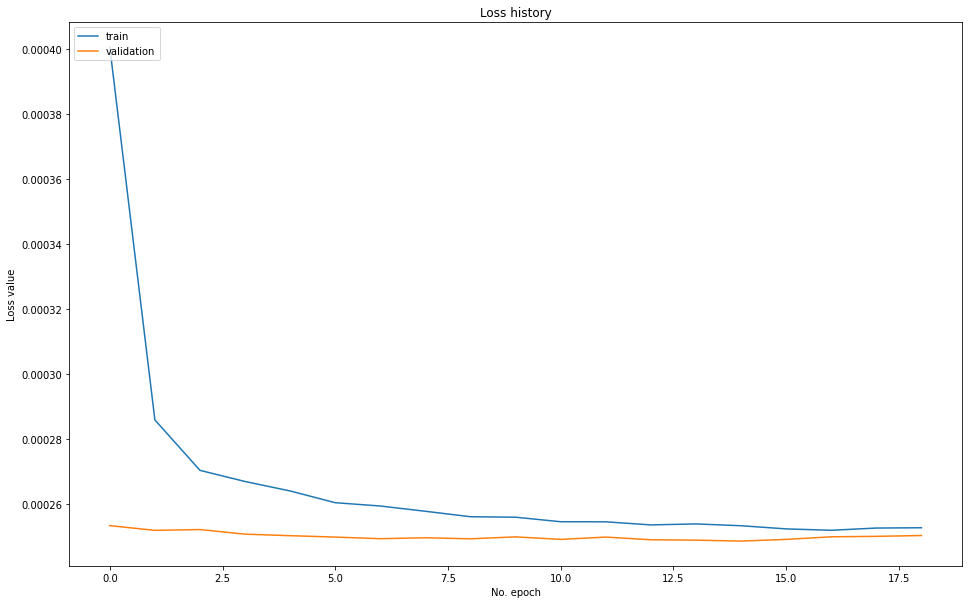

In [ ]:
show_history(history, metrics=['mape', 'r2_keras'])

In [ ]:
if lstm_model not in locals():
  lstm_model = keras.models.load_model('lstm_model.h5', compile=False)

In [ ]:
lstm_model.predict(x_test).shape

(489, 5, 5)

In [ ]:
print("Evaluate on test data")
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mape'])
results = lstm_model.evaluate(x_test, y_test, batch_size=128)
print('test loss:',results)

Evaluate on test data
4/4 [==============================] - 3s 465ms/step - loss: 6.5377e-04 - mape: 1717.4309
test loss: [0.0006537681329064071, 1717.430908203125]


# Etapa 4 - Pesos en la cartera

## 01 - Planto semilla

In [ ]:
reset_random_seeds()

## 02 - Importo los datos

In [ ]:
if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  df = data
  
stocks = ['IVZ', 'JBHT', 'J', 'ITW', 'JCI']

## 03 - Creo modelo segun la MPT para comparar con la red

In [ ]:
close_prices = df['Close'][stocks].pct_change().dropna(how='all').fillna(0)

In [ ]:
len_data_train = int(len(close_prices)*0.7)+1
len_data_val = int(len(close_prices)*0.15)+1

data_train = close_prices[0:len_data_train+len_data_val]

In [ ]:
close_prices = data_train.copy()

In [ ]:
variance_matrix = close_prices.cov()*252
variance_matrix

,IVZ,JBHT,J,ITW,JCI
IVZ,0.128926,0.048488,0.068504,0.051964,0.047575
JBHT,0.048488,0.067114,0.042505,0.034057,0.030480
J,0.068504,0.042505,0.098276,0.044760,0.040682
ITW,0.051964,0.034057,0.044760,0.053592,0.032909
JCI,0.047575,0.030480,0.040682,0.032909,0.061616


In [ ]:
port_returns = []
port_volatility = []
port_weights = []

num_assets = 5
num_portfolios = 10000

individual_rets = close_prices.resample('Y').last().pct_change().mean()

In [ ]:
reset_random_seeds()
for port in range(num_portfolios):
  weights = np.random.random(num_assets)
  weights = weights/np.sum(weights)

  port_weights.append(weights)
  
  returns = np.dot(weights, individual_rets)
  port_returns.append(returns)

  var = variance_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()

  sd = np.sqrt(var)

  ann_sd = sd * np.sqrt(252)

  port_volatility.append(ann_sd)

In [ ]:
results = {'Returns': port_returns, 'Volatility': port_volatility}

for counter, symbol in enumerate(close_prices.columns.tolist()):
  results[symbol+ ' weight'] = [w[counter] for w in port_weights]

portfolios_V1 = pd.DataFrame(results)
portfolios_V1.head()

,Returns,Volatility,IVZ weight,JBHT weight,J weight,ITW weight,JCI weight
0,-0.825512,3.686431,0.262848,0.454020,0.000072,0.190560,0.092500
1,0.284539,3.439183,0.059201,0.119417,0.221550,0.254380,0.345452
2,-0.579285,3.589727,0.189306,0.309442,0.092330,0.396554,0.012368
3,-2.089390,4.009684,0.337775,0.210234,0.281463,0.070726,0.099802
4,-0.764737,3.551167,0.219313,0.265194,0.085843,0.189618,0.240032


Text(0, 0.5, 'Expected Returns')

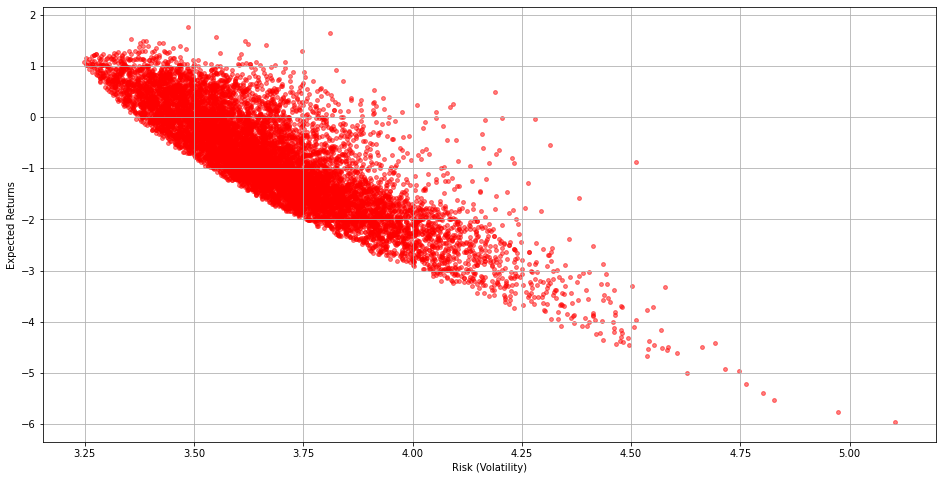

In [ ]:
portfolios_V1.plot.scatter(x='Volatility', y='Returns', marker='o', color='r', s=15, alpha=0.5, grid=True, figsize=[16,8])
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')

In [ ]:
optimal_risky_port = portfolios_V1.iloc[(portfolios_V1['Returns']/portfolios_V1['Volatility']).idxmax()]
optimal_risky_port

Returns        1.762235
Volatility     3.486567
IVZ weight     0.000137
JBHT weight    0.618745
J weight       0.026643
ITW weight     0.065965
JCI weight     0.288510
Name: 7030, dtype: float64

In [ ]:
pd.DataFrame([optimal_risky_port], columns=optimal_risky_port.index).to_csv('optimal_classic_weigths.csv')

In [ ]:
min_vol_port = portfolios_V1.iloc[(portfolios_V1['Volatility']).idxmin()]
min_vol_port

Returns        1.069657
Volatility     3.247057
IVZ weight     0.006811
JBHT weight    0.234895
J weight       0.005575
ITW weight     0.442019
JCI weight     0.310700
Name: 5609, dtype: float64

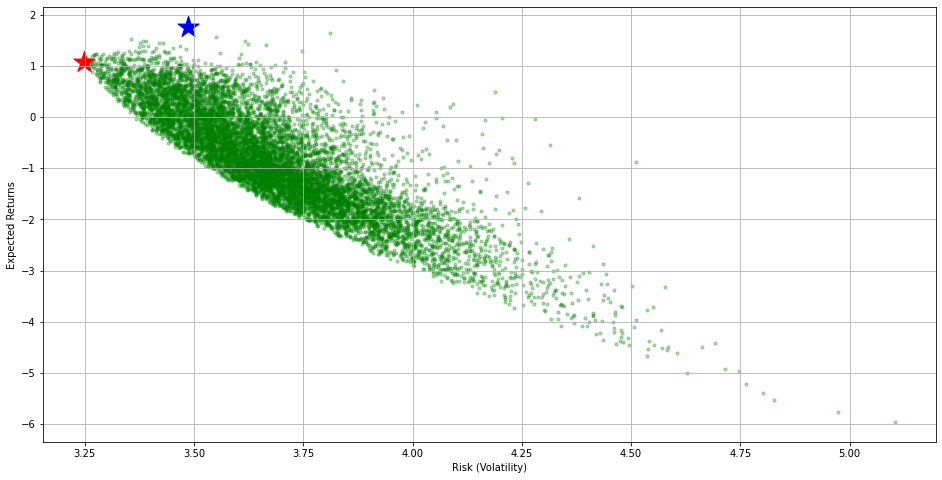

In [ ]:
plt.subplots(figsize=[16,8])
plt.scatter(portfolios_V1['Volatility'], portfolios_V1['Returns'], marker='o', s=10, alpha=0.3,  color='green')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], marker='*', s=500, color='b')
plt.grid(True)
plt.scatter(min_vol_port[1], min_vol_port[0], marker='*', s=500, color='red')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')
plt.show()

## 04 - Creo la Red Neuronal  

In [ ]:
if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  if data.shape == (3297, 3024):
    df = data
  else:
    df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
    df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
    df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
    df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
    df.index.name = None  # rename the index
  
stocks = ['IVZ', 'JBHT', 'J', 'ITW', 'JCI']

close_prices = df['Close'][stocks].pct_change().dropna(how='all').fillna(0)

In [ ]:
len_data_train = int(len(close_prices)*0.7)+1
len_data_val = int(len(close_prices)*0.15)+1
len_data_test = int(len(close_prices)*0.15)
print(len_data_train+len_data_val+len_data_test)

# choose a number of time steps
n_steps_in, n_steps_out = 5, 1

data_train = close_prices[0:len_data_train]
data_val = close_prices[len_data_train-n_steps_in:len_data_train+len_data_val]
data_test = close_prices[len_data_train+len_data_val-(n_steps_in):]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)
print(data_train.shape[0]+data_val.shape[0]-n_steps_in+data_test.shape[0]-n_steps_in)

3297
(2308, 5)
(500, 5)
(498, 5)
3296


In [ ]:
# define input sequence
data = data_train 

stocks = dict()
for stock in data.columns.tolist():
    stocks[stock] = np.array(data[stock])


for stock in data.columns.tolist():
  stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_train.shape, y_train.shape)

# define input sequence
data = data_val 

stocks = dict()
for stock in data.columns.tolist():
    stocks[stock] = np.array(data[stock])


for stock in data.columns.tolist():
  stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_val, y_val = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_val.shape, y_val.shape)

# define input sequence
data = data_test 

stocks = dict()
for stock in data.columns.tolist():
    stocks[stock] = np.array(data[stock])


for stock in data.columns.tolist():
  stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_test, y_test = split_sequences(dataset, n_steps_in, n_steps_out)
print(x_test.shape, y_test.shape)

(2303, 5, 5) (2303, 1, 5)
(495, 5, 5) (495, 1, 5)
(493, 5, 5) (493, 1, 5)


In [ ]:
batch_size_model = int(x_train.shape[0]/7)

In [ ]:
cov = close_prices.cov()*252
cov = cov.values
x = tf.constant(cov, dtype=tf.float32)

cov = np.repeat(x[None,:], batch_size_model, axis=0)
cov.shape

(329, 5, 5)

In [ ]:
input_data = Input(shape=(5,5))
layer = Dense(units=250, activation='selu')(input_data)
layer = BatchNormalization()(layer)
layer = Dropout(0.15)(layer)
layer = Dense(units=150, activation='selu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.15)(layer)
layer = Dense(units=100, activation='selu')(input_data)
layer = BatchNormalization()(layer)
layer = Dropout(0.15)(layer)
layer = Dense(units=50, activation='selu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.15)(layer)
layer = Dense(units=25, activation='selu')(layer)
output = Dense(units=5, activation='softmax')(layer)

In [ ]:
def sharpe_loss(y_pred, input_data, cov_input=cov, shape=batch_size_model):
    y_pred = tf.cast(y_pred, tf.float32)
  
    cov = tf.cast(cov_input, tf.float32)
    
    input_data = tf.cast(input_data, tf.float32)

    first_value = K.batch_dot(y_pred, cov)
    
    y_pred_reshaped = tf.reshape(y_pred, [shape, 5, 1])
    
    portfolio_variance = tf.math.reduce_sum(K.batch_dot(y_pred_reshaped,first_value))
  
    returns = tf.math.reduce_sum(K.batch_dot(y_pred, input_data))

    return -(returns / tf.math.sqrt(portfolio_variance))

In [ ]:
# creamos el modelo
model = Model(inputs=input_data, outputs=output)
print(model.summary())

# compilamos el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=sharpe_loss)

early_stopping = EarlyStopping(restore_best_weights=True)

reset_random_seeds()

history = model.fit(x_train, y_train, batch_size=batch_size_model, epochs=100)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 dense_11 (Dense)            (None, 5, 100)            600       
                                                                 
 batch_normalization_3 (Batc  (None, 5, 100)           400       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 5, 100)            0         
                                                                 
 dense_12 (Dense)            (None, 5, 50)             5050      
                                                                 
 batch_normalization_4 (Batc  (None, 5, 50)            200       
 hNormalization)                                           

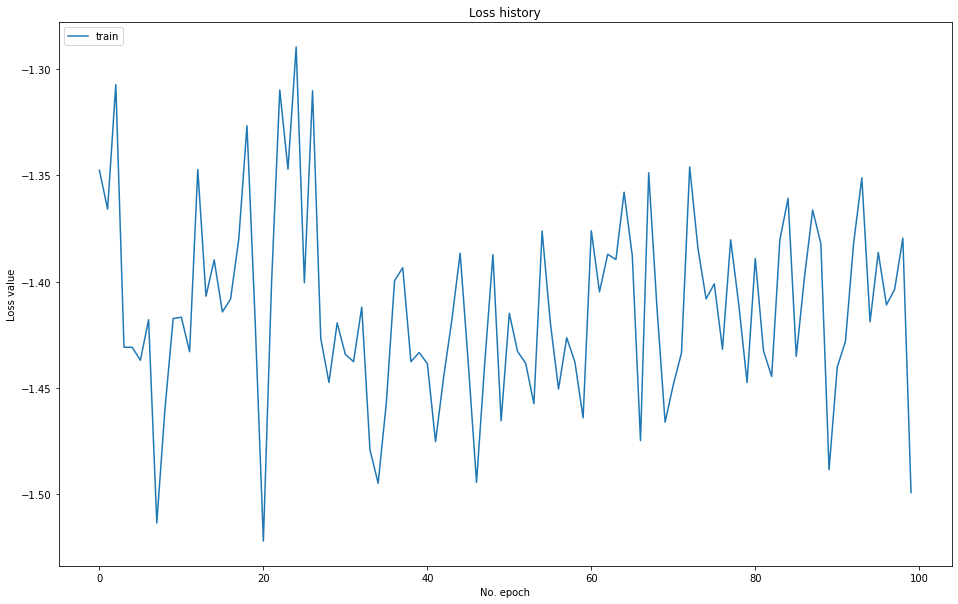

In [ ]:
plt.plot(history.history['loss'])
plt.title('Loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [ ]:
model.save('weigths_model.h5')
weigths_predictor = model

In [ ]:
if weigths_predictor not in locals():
  weigths_predictor = keras.models.load_model('weigths_model.h5', compile=False)

In [ ]:
y_pred = weigths_predictor.predict(x_test)

weights_nn = []
for j in range(y_pred.shape[0]):
  weights_nn.append(y_pred[j].mean(axis=0))
weights_nn = np.array(weights_nn)

In [ ]:
portfolio_return_nn = []
port_volatility_nn = []

for i in range(weights_nn.shape[0]):
  portfolio_return_nn.append(x_train[i].dot(weights_nn[i])) 

  variance_matrix_nn = pd.DataFrame(x_train[i]).cov()*252
  var_nn = variance_matrix_nn.mul(weights_nn[i], axis=0).mul(weights_nn[i], axis=1).sum().sum()
  sd_nn = np.sqrt(var_nn)
  ann_sd_nn = sd * np.sqrt(252)
  port_volatility_nn.append(ann_sd_nn)

In [ ]:
np.sum(portfolio_return_nn)

2.2441897863977447

In [ ]:
np.mean(port_volatility_nn)

3.685996595303038

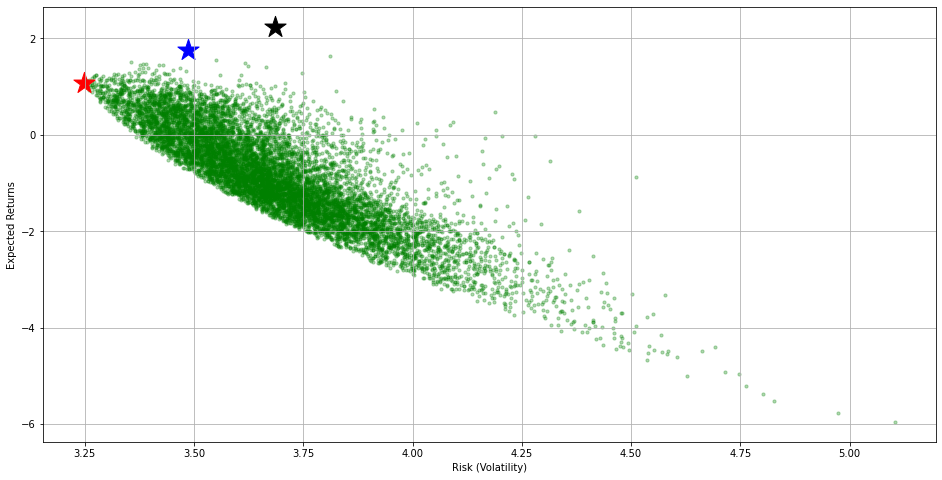

In [ ]:
plt.subplots(figsize=[16,8])
plt.scatter(portfolios_V1['Volatility'], portfolios_V1['Returns'], marker='o', s=10, alpha=0.3,  color='green')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], marker='*', s=500, color='b')
plt.grid(True)
plt.scatter(min_vol_port[1], min_vol_port[0], marker='*', s=500, color='red')
plt.scatter(np.mean(port_volatility_nn), np.sum(portfolio_return_nn), marker='*', s=500, color='black')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')
plt.show()

# Etapa 5: Resultados Finales

In [ ]:
reset_random_seeds()

if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  if data.shape == (3297, 3024):
    df = data
  else:
    df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
    df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
    df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
    df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
    df.index.name = None  # rename the index

stocks = ['IVZ', 'JBHT', 'J', 'ITW', 'JCI']

close_prices = df['Adj Close'][stocks].diff(1).dropna(how='all')

len_data_train = int(len(close_prices)*0.7)+1
len_data_val = int(len(close_prices)*0.15)+1
len_data_test = int(len(close_prices)*0.15)

# choose a number of time steps
n_steps_in, n_steps_out = 300, 1

data_train = close_prices[0:len_data_train]
data_val = close_prices[len_data_train-n_steps_in:len_data_train+len_data_val]
data_test = close_prices[len_data_train+len_data_val-(n_steps_in):]

# define input sequence
close_prices = data_train

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)

close_prices = data_val

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_val, y_val = split_sequences(dataset, n_steps_in, n_steps_out)

close_prices = data_test

stocks = dict()
for stock in close_prices.columns.tolist():
		stocks[stock] = np.array(close_prices[stock])


for stock in close_prices.columns.tolist():
	stocks[stock] = stocks[stock].reshape((len(stocks[stock]), 1))

dataset = np.hstack(stocks[k] for k in sorted(stocks))

# covert into input/output
x_test, y_test = split_sequences(dataset, n_steps_in, n_steps_out)

In [ ]:
if 'lstm_model' not in locals():
  lstm_model = keras.models.load_model('lstm_model.h5')

if 'weigths_model' not in locals():
  weigths_model = keras.models.load_model('weigths_model.h5', compile=False)

In [ ]:
returns_predicted = lstm_model.predict(x_test)

In [ ]:
weigths_predicted = weigths_model.predict(returns_predicted)

In [ ]:
weigths_predicted.shape

(492, 5, 5)

In [ ]:
weigths = predict_weigths(x_test)
weigths.shape

(492, 5)

In [ ]:
np.sum(weigths[0]*y_test[0])

0.39175672418867713

In [ ]:
final_results = []

for i in range(y_test.shape[0]):
  final_results.append(np.sum(weigths[i]*y_test[i]))

In [ ]:
np.sum(final_results)

52.39352767137271

In [ ]:
optimal_classic_weigths = pd.read_csv('optimal_classic_weigths.csv')

In [ ]:
optimal_classic_weigths = optimal_classic_weigths[['IVZ weight', 'JBHT weight', 'J weight', 'ITW weight', 'JCI weight']]
optimal_classic_weigths

,IVZ weight,JBHT weight,J weight,ITW weight,JCI weight
0,0.000137,0.618745,0.026643,0.065965,0.28851


In [ ]:
final_classic_results = []

for i in range(y_test.shape[0]):
  final_classic_results.append(np.sum(optimal_classic_weigths*y_test[i]))

In [ ]:
reset_random_seeds()

if 'data' not in vars():
  df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
  df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
  df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
  df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
  df.index.name = None  # rename the index
else:
  if data.shape == (3297, 3024):
    df = data
  else:
    df = pd.read_csv('/content/drive/MyDrive/TFM_DataScience/01_Amadeo_Ancarani/Data/datos_tfm.csv', header=[0, 1])
    df.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
    df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(df[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
    df.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
    df.index.name = None  # rename the index

stocks = ['IVZ', 'JBHT', 'J', 'ITW', 'JCI']

close_prices = df['Adj Close'][stocks].diff(1).dropna(how='all')

len_data_train = int(len(close_prices)*0.7)+1
len_data_val = int(len(close_prices)*0.15)+1
len_data_test = int(len(close_prices)*0.15)

# choose a number of time steps
n_steps_in, n_steps_out = 300, 1

data_train = close_prices[0:len_data_train]
data_val = close_prices[len_data_train-n_steps_in:len_data_train+len_data_val]
data_test = close_prices[len_data_train+len_data_val:]

data_test = close_prices[len_data_train+len_data_val:]

In [ ]:
final_classic_results = pd.DataFrame(data_test, columns=stocks)
for i in final_classic_results.columns.tolist():
  final_classic_results[i] = final_classic_results[i] * optimal_classic_weigths[i + ' weight'].iloc[0]

In [ ]:
optimal_classic_weigths[final_classic_results.columns.tolist()[0] + ' weight'].iloc[0]

0.0001369655488862

In [ ]:
final_classic_results['result'] = final_classic_results['IVZ'] + final_classic_results['JBHT'] + final_classic_results['J'] + final_classic_results['ITW'] + final_classic_results['JCI']
np.sum(final_classic_results['result'])

65.17686350439682

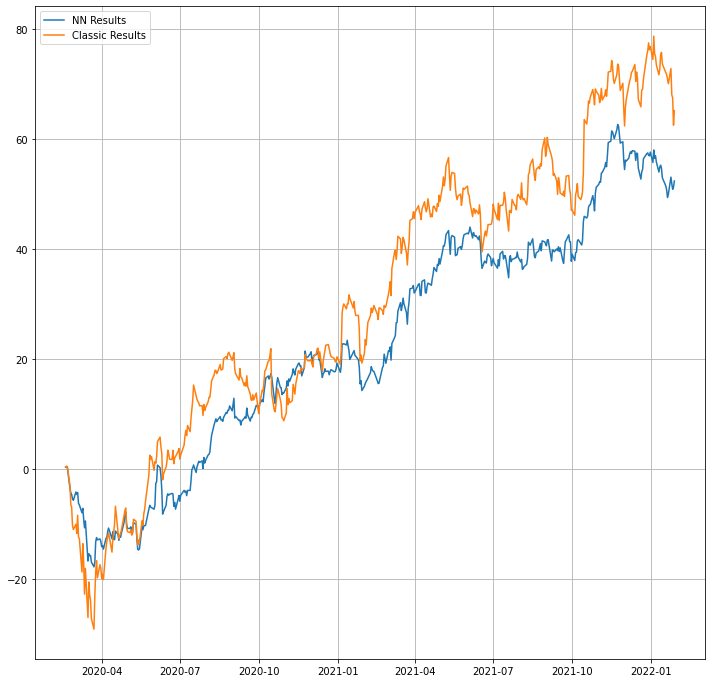

In [ ]:
plt.rcParams["figure.figsize"] = (12,12)
plt.plot(data_test.index, np.cumsum(final_results), label="NN Results")
plt.plot(data_test.index, np.cumsum(np.array(final_classic_results['result'])), label="Classic Results")
plt.legend(loc="upper left")
plt.grid(True)

In [ ]:
np.sum(final_results)

52.39352767137271

In [ ]:
np.sum(np.array(final_classic_results['result']))

65.17686350439682

In [ ]:
np.min(np.cumsum(np.array(final_classic_results['result'])))

-29.05542335040652

In [ ]:
np.min(np.cumsum(final_results))

-17.73716840970666